In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

import torch 
from transformers import AutoModelForSequenceClassification,Trainer,TrainingArguments
from transformers import AutoTokenizer,DataCollatorWithPadding
from datasets import Dataset
from datasets import load_metric


from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.expand_frame_repr', False) 


import warnings
warnings.filterwarnings("ignore")

import os
os.environ['WANDB_DISABLED'] = 'True'
    
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

random_state = 42


2024-06-10 06:53:22.440531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 06:53:22.440634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 06:53:22.563421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
tr = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print('Training Set = {}'.format(tr.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(tr.memory_usage().sum() / 1024**2))
print('Test Set = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))


Training Set = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
tr.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [4]:
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,"They'd probably still show more life than Arsenal did yesterday, eh? EH?"
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [5]:
tr['keyword'] = tr['keyword'].str.replace('%20', ' ')
test['keyword'] = test['keyword'].str.replace('%20', ' ')

In [6]:
print(tr[['keyword']].dropna(subset=['keyword']).head(50))
print(test[['keyword']].dropna(subset=['keyword']).head(50))

     keyword
31    ablaze
32    ablaze
33    ablaze
34    ablaze
35    ablaze
36    ablaze
37    ablaze
38    ablaze
39    ablaze
40    ablaze
41    ablaze
42    ablaze
43    ablaze
44    ablaze
45    ablaze
46    ablaze
47    ablaze
48    ablaze
49    ablaze
50    ablaze
51    ablaze
52    ablaze
53    ablaze
54    ablaze
55    ablaze
56    ablaze
57    ablaze
58    ablaze
59    ablaze
60    ablaze
61    ablaze
62    ablaze
63    ablaze
64    ablaze
65    ablaze
66    ablaze
67  accident
68  accident
69  accident
70  accident
71  accident
72  accident
73  accident
74  accident
75  accident
76  accident
77  accident
78  accident
79  accident
80  accident
              keyword
15             ablaze
16             ablaze
17             ablaze
18             ablaze
19             ablaze
20             ablaze
21             ablaze
22             ablaze
23             ablaze
24             ablaze
25             ablaze
26             ablaze
27             ablaze
28             ablaze
29     

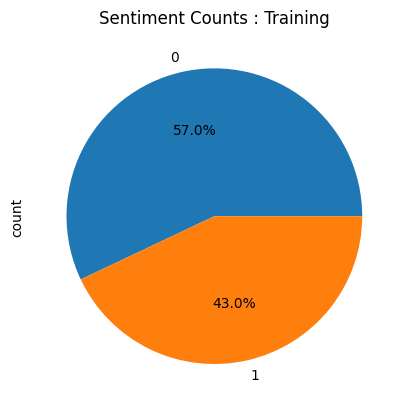

<Figure size 100x100 with 0 Axes>

In [7]:
# Plotting the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

plot = tr['target'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plot.set_title('Sentiment Counts : Training')
plt.figure(figsize=(1,1))
plt.show()

We notice that text data needs to be cleaned before building a model. 
Observing tweets, certain characters like "%20" are unwanted which have to be cleaned.

In [8]:
# PRERPOCESSING TEXT DATA
import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def tweets_cleaner(tweet):
  
    tweet = re.sub(r'((www.\S+)|(https?://\S+))', r"", tweet) #remove urls
    tweet = re.sub(r'#','', tweet) #remove hashtags symbol
    tweet = re.sub(r'[0-9]\S+', r'', tweet) #remove numbers
    tweet= re.sub(r'@[A-Za-z0-9]+', '',tweet)# removed @mentions
    tweet = re.sub(r'rt[^A-Za-z0-9]|RT!|rt!|', '',tweet)# removed RT
    tweet = re.sub(r'\b\w\b', '', tweet) # remove single characters
    tweet = re.sub(r'%20', ' ', tweet) # %20 by space
    tweet = re.sub(r'&amp;', ' ', tweet)
    tweet = re.sub(r'ûï(?!\w)', '', tweet)
    tweet = re.sub(r'.*ÛÏ.*', '', tweet)
    tweet = re.sub(r'û', '', tweet)
    tweet = re.sub(r'û', '', tweet)
    tweet = re.sub(r'Û', '', tweet)
    
    
    # removing punctuations from the text
    tweet_without_punctuation = [char for char in tweet if char not   
                                in string.punctuation]
    # converting the list to string 
    tweet_without_punctuation = "".join(tweet_without_punctuation) 
    # set of stop words 
    stop_words = set(stopwords.words("english"))
    # removing the stop words 
    tweet_without_stopwords = [word.lower() for word in  
                              tweet_without_punctuation.split()
                              if word.lower() not in stop_words]
    tweet_without_stopwords = [stemmer.stem(word) for word in tweet_without_stopwords]
    tweet_without_stopwords = ' '.join(tweet_without_stopwords)
    return tweet_without_stopwords

#function to join list to text
# def list_to_text(word_list):
#     return " ".join(word_list)

In [9]:
#split data in train and val set
train,valid = train_test_split(tr, test_size= 0.2,random_state = random_state)

In [10]:
train.isnull().sum()

id             0
keyword       48
location    2020
text           0
target         0
dtype: int64

In [11]:
#add keyword to tweet (compostite feature)
train['keyword'].fillna('a', inplace = True)
valid['keyword'].fillna('a', inplace = True)
test['keyword'].fillna('a', inplace = True)

train['text_new'] = train['text'] + " "+ train['keyword']
valid['text_new'] = valid['text'] + " "+ valid['keyword']
test['text_new'] = test['text'] + " " + test['keyword']


In [12]:
test.head()

,id,keyword,location,text,text_new
0,0,a,NaN,Just happened a terrible car crash,Just happened a terrible car crash a
1,2,a,NaN,"Heard about #earthquake is different cities, stay safe everyone.","Heard about #earthquake is different cities, stay safe everyone. a"
2,3,a,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all a"
3,9,a,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires a
4,11,a,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan a


In [13]:
train['processed_text']= train['text_new'].apply(tweets_cleaner)
valid['processed_text']=valid['text_new'].apply(tweets_cleaner)
test['processed_text']=test['text_new'].apply(tweets_cleaner)


In [14]:
pd.concat([test,train,valid]).isnull().sum()

id                   0
keyword              0
location          3638
text                 0
text_new             0
processed_text       0
target            3263
dtype: int64

In [15]:
train[['text', 'processed_text','target']].head(10)

,text,processed_text,target
4996,Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR,courag honest analysi need use atom bomb hiroshima japanes militari refus surrend militari,1
3263,@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears,wld shame golf cabecam engulf flame boycottbear engulf,0
4907,Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT! https://t.co/u4r8dRiuAc,tell rescind medal honor given us soldier massacr wound knee sign massacr,1
2855,Worried about how the CA drought might affect you? Extreme Weather: Does it Dampen Our Economy? http://t.co/fDzzuMyW8i,worri ca drought might affect extrem weather dampen economi drought,1
4716,@YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha,lava blast power red pantherattack lava,0
7538,Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/yi54XRHQGB,wreckag conclus confirm mh malaysia pm investig famili wreckag,1
3172,Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.,builder dental emerg ruin plan emot blackmail afternoon bump emerg plan,1
3932,BMX issues Areal Flood Advisory for Shelby [AL] till Aug 5 9:00 PM CDT http://t.co/62OddEkVLi,bmx issu areal flood advisori shelbi al till aug pm cdt flood,1
5833,#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/aOd2ftBMGU,china stock market crash gem rubbl rubbl,1
7173,@RobertONeill31 Getting hit by a foul ball while sitting there is hardly a freak accident. It's a war zone.,get hit foul ball sit hard freak accid war zone war zone,0


In [16]:
test[['text', 'processed_text']].head(10)

,text,processed_text
0,Just happened a terrible car crash,happen terribl car crash
1,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquak differ citi stay safe everyon
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond gees flee across street cannot save
3,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
5,We're shaking...It's an earthquake,shakingit earthquak
6,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",probabl still show life arsenal yesterday eh eh
7,Hey! How are you?,hey
8,What a nice hat?,nice hat
9,Fuck off!,fuck


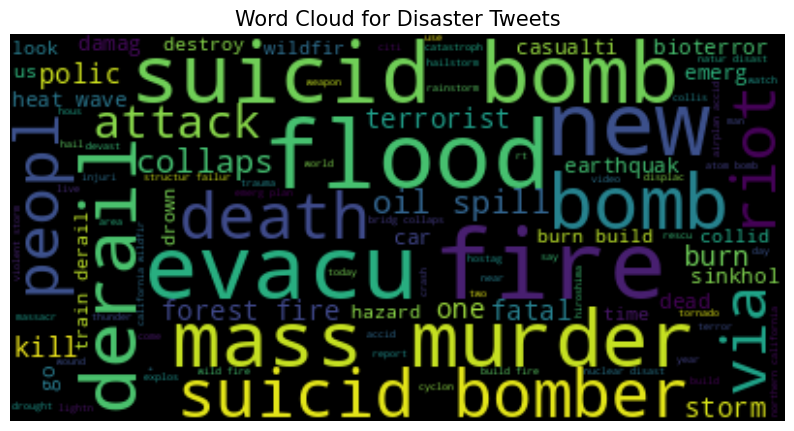

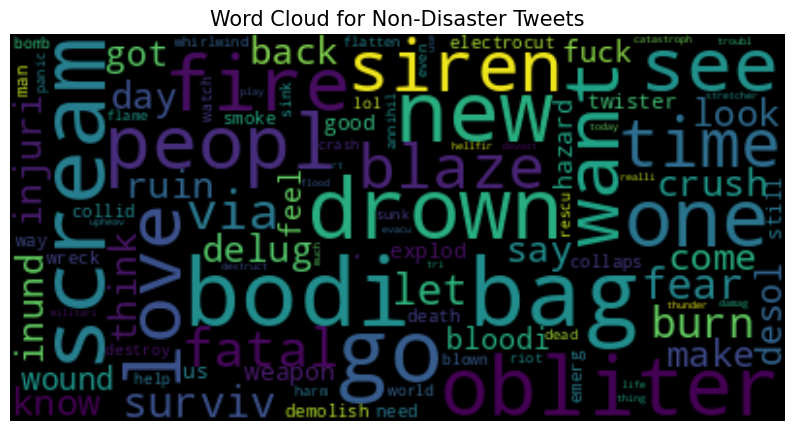

In [17]:
from wordcloud import WordCloud

# Generate a word cloud
def generate_word_cloud(data, title):
    text = " ".join(review for review in data)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis("off")
    plt.show()

# Generate word clouds for disaster and non-disaster tweets
disaster_tweets = train[train['target'] == 1]['processed_text']
non_disaster_tweets = train[train['target'] == 0]['processed_text']

generate_word_cloud(disaster_tweets, "Word Cloud for Disaster Tweets")
generate_word_cloud(non_disaster_tweets, "Word Cloud for Non-Disaster Tweets")

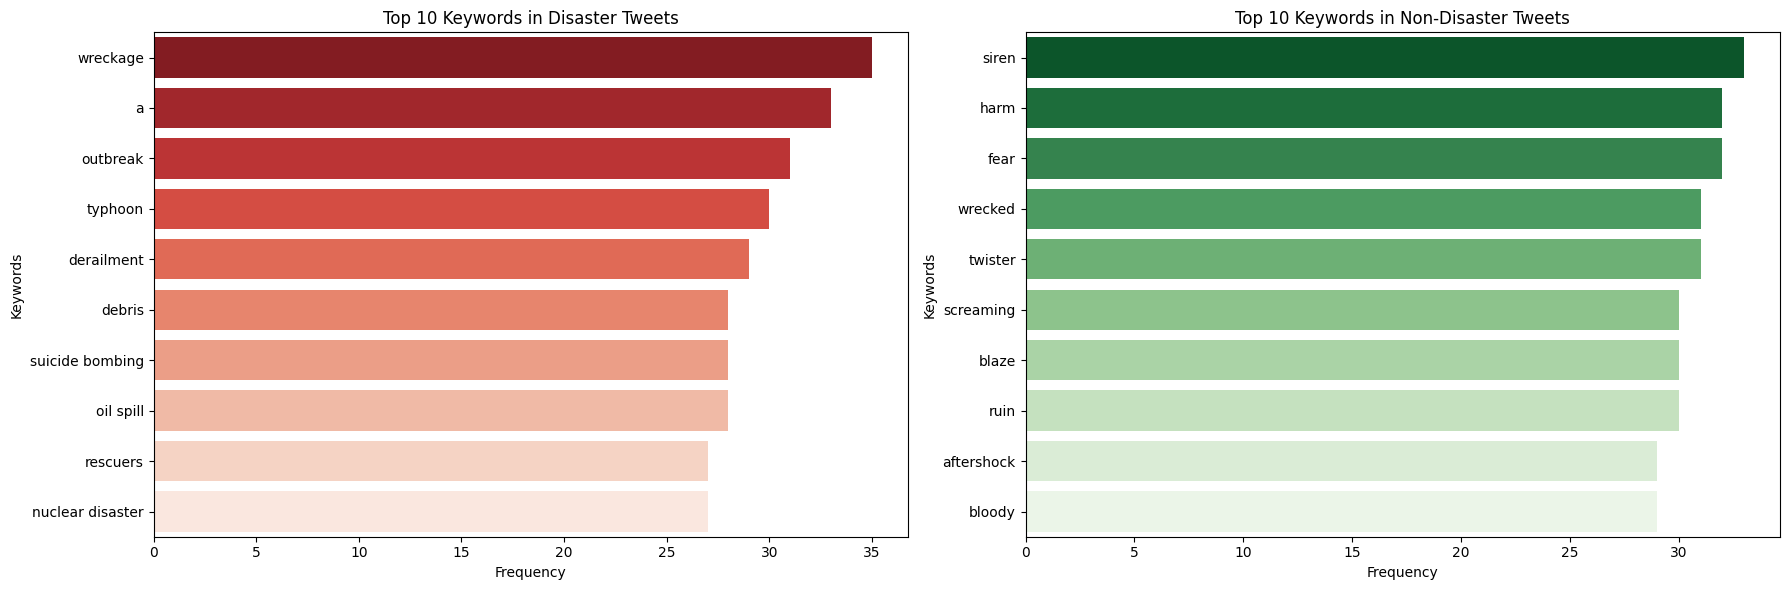

In [18]:
# train['keyword'] = train['keyword'].apply(tweets_cleaner).apply(list_to_text)
keyword_disaster = train[train['target'] == 1]['keyword'].value_counts().head(10)
keyword_non_disaster = train[train['target'] == 0]['keyword'].value_counts().head(10)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Disaster Keywords
sns.barplot(x=keyword_disaster.values, y=keyword_disaster.index, ax=ax[0], palette="Reds_r")
ax[0].set_title('Top 10 Keywords in Disaster Tweets')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Keywords')

# Non-Disaster Keywords
sns.barplot(x=keyword_non_disaster.values, y=keyword_non_disaster.index, ax=ax[1], palette="Greens_r")
ax[1].set_title('Top 10 Keywords in Non-Disaster Tweets')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Keywords')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

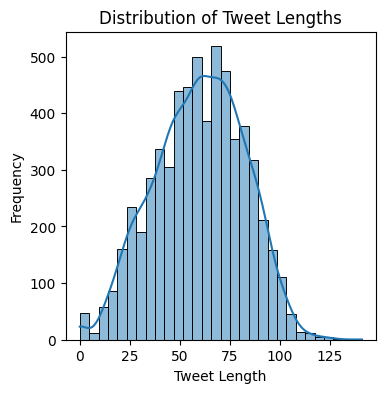

In [19]:
#visualising length of tweets to input max length in model
train['tweet_length'] = train['processed_text'].apply(len)
 
plt.figure(figsize=(4,4))
sns.histplot(data = train, x ='tweet_length', bins =30, kde = True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

In [20]:
def tokenization(model_path,train_df,valid_df,test_df):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    train_ds = Dataset.from_pandas(train_df)
    valid_ds = Dataset.from_pandas(valid_df)
    test_ds = Dataset.from_pandas(test_df)
    
    def process_token(example,tokenizer=tokenizer):
        return tokenizer(example['text'])
    
    tokenized_train = train_ds.map(process_token)
    tokenized_valid = valid_ds.map(process_token)
    tokenized_test = test_ds.map(process_token)
    
    columns_to_remove = ['id', 'keyword', 'location','__index_level_0__']
    train_dataset = tokenized_train.remove_columns(columns_to_remove)
    valid_dataset = tokenized_valid.remove_columns(columns_to_remove)
    columns_to_remove = ['id', 'keyword', 'location']
    test_dataset = tokenized_test.remove_columns(columns_to_remove)
    
    train_dataset = train_dataset.rename_column("target", "label")
    valid_dataset = valid_dataset.rename_column("target", "label")
    
    return train_dataset,valid_dataset,test_dataset,tokenizer

In [21]:
def compute_metrics(eval_pred):
    load_acc = load_metric('accuracy')
    load_f1 = load_metric('f1')
    logits,labels = eval_pred
    predictions = np.argmax(logits,axis = -1)
    acc = load_acc.compute(predictions = predictions,references = labels)['accuracy']
    f1 = load_f1.compute(predictions = predictions, references = labels)['f1']
    return {'acc':acc,'f1':f1}

In [22]:
def init_trainer(model_path,tokenizer,lr,ep,train_dataset,valid_dataset):
    model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=2)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    training_args = TrainingArguments(
        learning_rate=lr,
        num_train_epochs=ep,
        per_device_train_batch_size=16,
        weight_decay=0.01,
        output_dir=model_path,

    )
    trainer = Trainer(
        model = model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    return trainer

In [23]:
class model_fusion:
    def __init__(self,model_paths,save_paths,lr,ep):
        self.model_paths = model_paths
        self.save_paths = save_paths
        self.learning_rate = lr
        self.epoch_num = ep
        self.preds = []
    
    def train_pred_multiple_models(self):
        for model_path, save_path in zip(self.model_paths, self.save_paths):
            print(f'Training {model_path}')
            print('total:',torch.cuda.get_device_properties(0).total_memory/1e9)
            print('allocated:',torch.cuda.memory_allocated(0)/1e9)
            print('cached:',torch.cuda.memory_reserved(0)/1e9)
            
            train_dataset,valid_dataset,test_dataset,tokenizer = tokenization(model_path,train,valid,test)
            trainer = init_trainer(model_path,tokenizer,self.learning_rate,self.epoch_num,train_dataset,valid_dataset)
            trainer.train()
            
            self.save_model(trainer.model, save_path)
            
            prediction = trainer.predict(test_dataset=test_dataset)
            predictions = np.argmax(a=prediction.predictions,axis = -1)
            self.preds.append((model_path,predictions))
            
            
    def fusion_pred(self):
        all_preds = [pred[1] for pred in self.preds]
        final_preds = mode(all_preds, axis=0)[0]

        return final_preds.ravel()
    
    def save_model(self, model, save_path):
        model.save_pretrained(save_path)

In [24]:
distilbert_path = 'distilbert/distilbert-base-uncased' # faster & more efficient bert
roberta_path = 'FacebookAI/roberta-base' # faster & more efficient bert
deberta_path = 'microsoft/deberta-v3-base' # Improved performance over BERT and RoBERTa in complex NLP tasks
# xlnet_path = 'xlnet/xlnet-base-cased'  # Combines the advantages of BERT and Transformer-XL, capturing bidirectional context better
albert_path = 'albert/albert-base-v2' # Efficiency and performance with reduced model size

# model_paths = [distilbert_path,roberta_path,deberta_path,xlnet_path ,albert_path]
model_paths = [distilbert_path,roberta_path,deberta_path ,albert_path]

lr = 2e-5
ep = 3

save_root = "/kaggle/working/"
# save_paths = [save_root + 'distilbert', save_root + 'roberta', save_root +  'deberta', save_root + 'xlnet_path', save_root + 'albert_path']

save_paths = [save_root + 'distilbert', save_root + 'roberta', save_root +  'deberta', save_root + 'albert_path']

models = model_fusion(model_paths,save_paths,lr,ep)


In [25]:
models.train_pred_multiple_models()
pred = models.fusion_pred()
models.preds

Training distilbert/distilbert-base-uncased
total: 15.835660288
allocated: 0.0
cached: 0.0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.360600


Training FacebookAI/roberta-base
total: 15.835660288
allocated: 0.8323328
cached: 1.71966464


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.373400


Training microsoft/deberta-v3-base
total: 15.835660288
allocated: 1.534016512
cached: 3.238002688


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.372300


Training albert/albert-base-v2
total: 15.835660288
allocated: 2.245507584
cached: 5.624561664


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.392200


[('distilbert/distilbert-base-uncased', array([1, 1, 1, ..., 1, 1, 1])),
 ('FacebookAI/roberta-base', array([1, 1, 1, ..., 1, 1, 1])),
 ('microsoft/deberta-v3-base', array([1, 1, 1, ..., 1, 1, 1])),
 ('albert/albert-base-v2', array([1, 1, 1, ..., 1, 1, 1]))]

In [26]:
all_preds = [pred[1] for pred in models.preds]
final_preds = mode(all_preds, axis=0)[0]
final_preds = final_preds.ravel()

In [27]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = final_preds
submission = submission.set_index('id',drop=True)
submission.to_csv('/kaggle/working/submission.csv')

In [28]:
submission.head(10)

,target
id,
0,1
2,1
3,1
9,1
11,1
12,1
21,0
22,0
27,0
